In [2]:
%pylab inline
import numpy as np
import pandas as pd
from datetime import date,datetime
import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import warnings
from collections import OrderedDict

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
filename1 = "Translation_Test/test_table.csv"
filename2 = "Translation_Test/user_table.csv"
test_data = pd.read_csv(filename1) #, encoding = "ISO-8859-1",na_values=['','None','NA'])
user_data = pd.read_csv(filename2) #, encoding = "ISO-8859-1",na_values=['','None','NA'])

print(test_data.info())
print(user_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB
None


In [3]:
test_data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
user_data.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
# Check primary key 
print("User data id unique: ",len(user_data['user_id']) == len(set(user_data['user_id'])))  # Unique
# set(a).issubset(b) ;  (1,2,3) < (1,2,3,4)
print("All users in test has user info: ",set(test_data['user_id']).issubset(set(user_data['user_id']))) 
# Test data has some new users doesn't exist in user data

# set(test_data['user_id']) < set(user_data['user_id'])  # everyone in one table also in the

User data id unique:  True
All users in test has user info:  False


In [5]:
# Join two datasets, pay attention to missing user data
data = pd.merge(test_data, user_data, how='left', on='user_id')
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d").dt.date
data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [6]:
data.describe(include = 'all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000,452867,452867.000000,452867
unique,NaN,5,3,2,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,M,NaN,Mexico
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN,264485,NaN,128484
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446,NaN,27.130740,NaN
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445,NaN,6.776678,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN


In [7]:
# Check missing values
data.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

In [8]:
# Check conversion rate by country, sort by descending order
country = data.groupby(['country'], sort=True)['conversion'].mean().reset_index(name='conversion_rate').sort_values(['conversion_rate'], ascending=False)
country

,country,conversion_rate
14,Spain,0.079719
4,Costa Rica,0.053494
10,Nicaragua,0.053399
3,Colombia,0.051332
6,El Salvador,0.050765
9,Mexico,0.050341
13,Peru,0.050258
2,Chile,0.049704
16,Venezuela,0.049666
7,Guatemala,0.049653


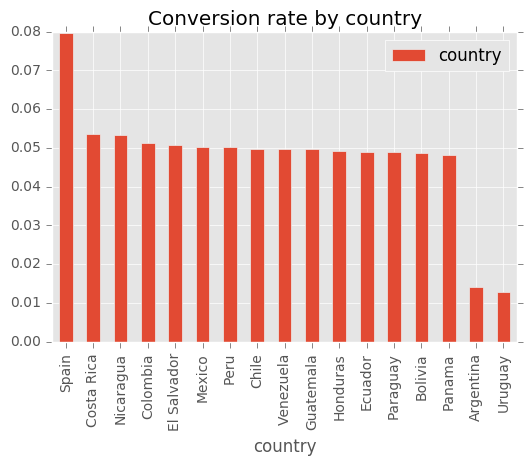

In [9]:
# pandas.DataFrame.plot
country.plot(kind='bar', x='country', y='conversion_rate', label='country',title = 'Conversion rate by country')

### T-test
#### What is t-test?
The t test (also called Student’s T Test) compares two averages (means) and tells you if they are different from each other. The t test also tells you how significant the differences are; In other words it lets you know if those differences could have happened by chance.

In [10]:
# data_test = data[country != "Spain"]
data_test = data.loc[data['country'] != "Spain"]
print('Control Group:', mean(data_test['conversion'][data_test['test'] == 0]))
print('Test Group:', mean(data_test['conversion'][data_test['test'] == 1]))

stats.ttest_ind(a = data_test['conversion'][data_test['test'] == 0],
                b = data_test['conversion'][data_test['test'] == 1])  # Pop mean
# t.test(data_test$conversion[data_test$test == 1], data_test$conversion[data_test$test == 0])

Control Group: 0.04833042316066309
Test Group: 0.043424713982118966


Ttest_indResult(statistic=7.4225120959547688, pvalue=1.15144687852198e-13)

Mmh... not in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:  
* We didn’t collect enough data.  
* Some bias has been introduced in the experiment so that test/control people are not really random.  


**In data science, whenever results appear too bad or too good to be true, they are not true.**  
Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden.

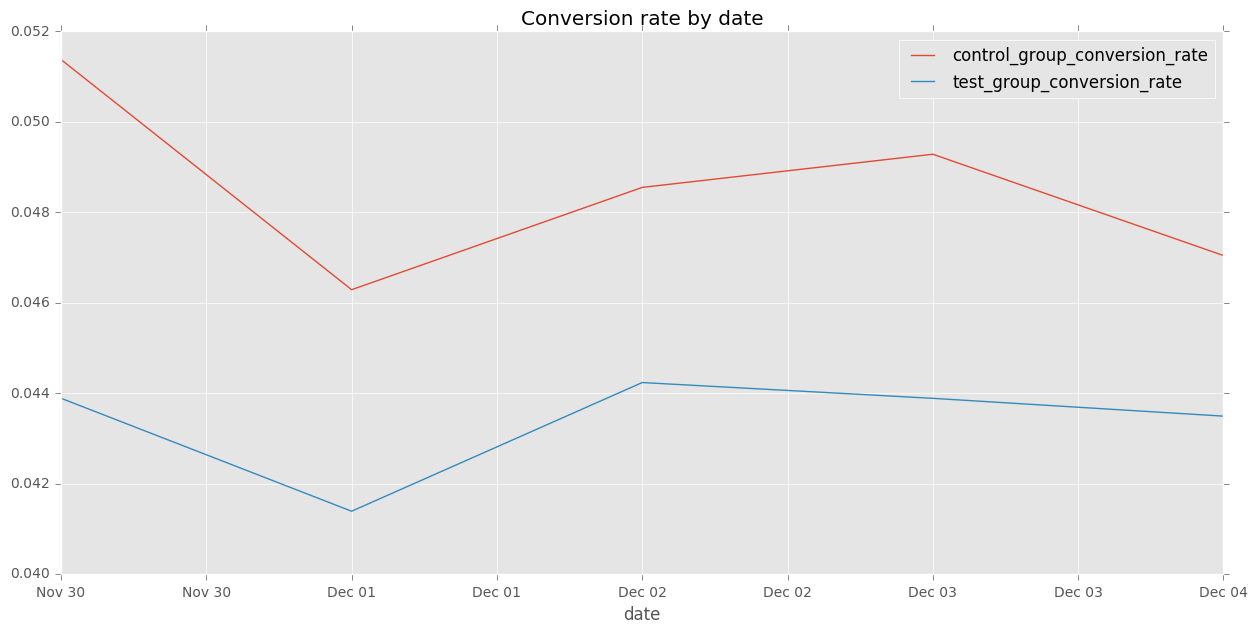

In [11]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,7))
# data.plot(ax=ax)


date0 = data_test[data_test['test'] == 0].groupby(['date'], sort=True)['conversion'].mean().reset_index(name='control_group_conversion_rate').sort_values(['control_group_conversion_rate'], ascending=False)
date1 = data_test[data_test['test'] == 1].groupby(['date'], sort=True)['conversion'].mean().reset_index(name='test_group_conversion_rate').sort_values(['test_group_conversion_rate'], ascending=False)
date0.plot(ax=ax,kind='line', x='date', y='control_group_conversion_rate', label='control_group_conversion_rate',title = 'Conversion rate by date')
date1.plot(ax=ax,kind='line', x='date', y='test_group_conversion_rate', label='test_group_conversion_rate',title = 'Conversion rate by date')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# fig, ax = plt.subplots()

# for subdata in data_test.groupby(['date'])['conversion'].mean():
#     ax = grp.plot(ax=ax, kind='line', x='x', y='y', c=key, label=key)


In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 12 columns):
user_id             401539 non-null int64
date                401539 non-null object
source              401539 non-null object
device              401539 non-null object
browser_language    401539 non-null object
ads_channel         160984 non-null object
browser             401539 non-null object
conversion          401539 non-null int64
test                401539 non-null int64
sex                 401085 non-null object
age                 401085 non-null float64
country             401085 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 39.8+ MB


From the plot, we notice a couple of things:  
1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.  
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.  

Time to find out the bias! Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.  
In an ideal world, the distribution of people in test and control for each segment should be the same. There are many ways to this. One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).  
Let’s check this:  

In [13]:
clf = DecisionTreeClassifier(max_depth = 5)
model_data = data_test.dropna()
x = model_data.drop(['test',"user_id", "conversion"], axis=1)
X = pd.get_dummies(x, columns = ["sex","date","source","device","browser_language","ads_channel","browser","country"])
Y = model_data['test'] 
X.head(5)
# X['age'].isnull().mean()  #0.1% missing
clf = clf.fit(X, Y)

In [20]:
feature_names=X.columns
print(feature_names)

Index(['age', 'sex_F', 'sex_M', 'date_2015-11-30', 'date_2015-12-01',
       'date_2015-12-02', 'date_2015-12-03', 'date_2015-12-04', 'source_Ads',
       'device_Mobile', 'device_Web', 'browser_language_EN',
       'browser_language_ES', 'browser_language_Other', 'ads_channel_Bing',
       'ads_channel_Facebook', 'ads_channel_Google', 'ads_channel_Other',
       'ads_channel_Yahoo', 'browser_Android_App', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Iphone_App', 'browser_Opera',
       'browser_Safari', 'country_Argentina', 'country_Bolivia',
       'country_Chile', 'country_Colombia', 'country_Costa Rica',
       'country_Ecuador', 'country_El Salvador', 'country_Guatemala',
       'country_Honduras', 'country_Mexico', 'country_Nicaragua',
       'country_Panama', 'country_Paraguay', 'country_Peru', 'country_Uruguay',
       'country_Venezuela'],
      dtype='object')


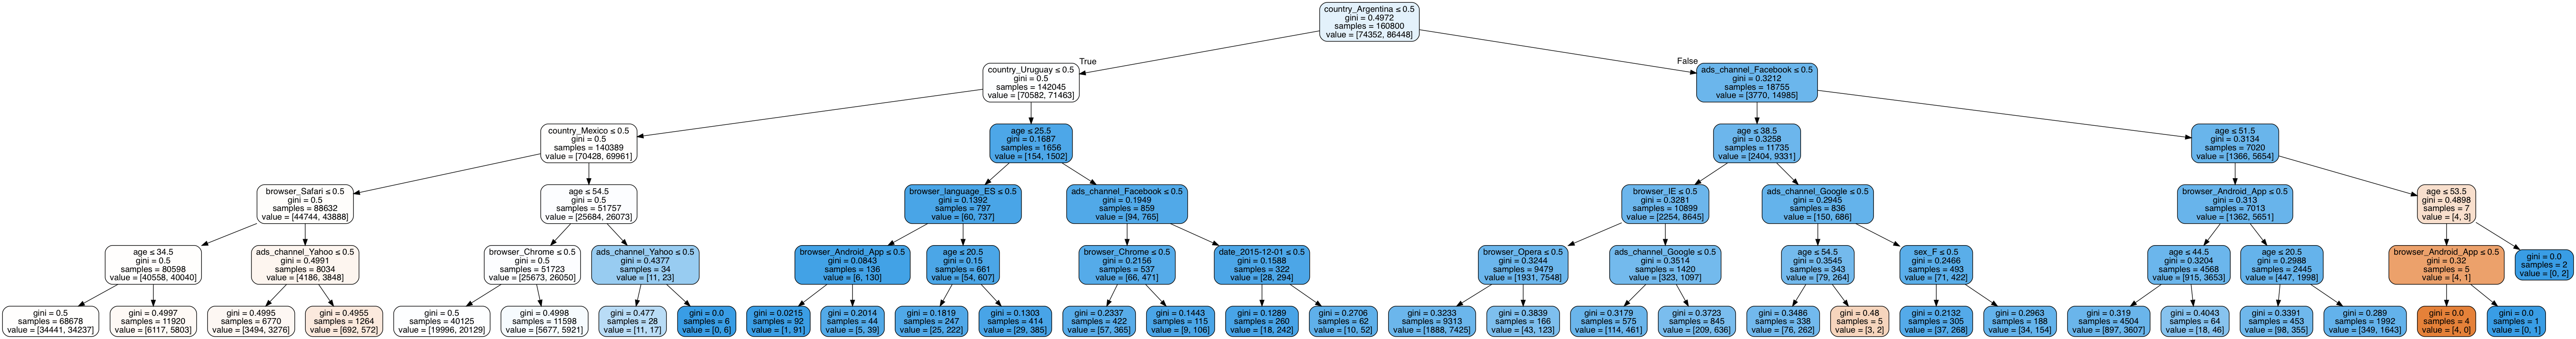

In [24]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                feature_names=feature_names,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# graph.write_png("spanish_test.png")

Looks very interesting.  
The randomization is perfect for the countries on one side of the split (country=Bolivia, Chile, Colombia, Costa Rica, Ecuador, EL Salvador, Guatemala, Honduras, Mexico, Nicaragua, Panama, Paraguay, Peru, Venezuela). Indeed, in that leaf the test/control ratio is 0.498! However, Argentina and Uruguay together have 80% test and 20% control! So let’s check the test results after controlling for country. 

That is, we check for each country how the test is doing:

In [24]:
res_df = pd.DataFrame(None, columns=['country','Control Group Mean', 'Test Group Mean', 'P value'])
res_df

,country,Control Group Mean,Test Group Mean,P value


In [37]:
countries = set(data_test['country'])
Control_group = []
Test_group = []
pvalue = []
for country in countries:
    country_test = data_test[data_test['country'] == country]
    Control_group.append(mean(country_test['conversion'][data_test['test'] == 0]))
    Test_group.append(mean(country_test['conversion'][data_test['test'] == 1]))
#     print('Country, %s, Control Group: %0.4f, Test Group:%0.4f'%(country, Control_group, Test_group))
    statistic, p_value = stats.ttest_ind(a = country_test['conversion'][data_test['test'] == 0],
                b = country_test['conversion'][data_test['test'] == 1])
    pvalue.append(p_value)
    

In [41]:
res_data = {
    "country":list(countries),
    "Control Mean": Control_group,
    'Test Mean': Test_group,
    'pvalue': pvalue
}
result = pd.DataFrame(res_data,columns=['country','Control Mean', 'Test Mean', 'pvalue'])
result.dropna()

,country,Control Mean,Test Mean,pvalue
0,El Salvador,0.053554,0.047947,0.248251
1,Ecuador,0.049154,0.048988,0.961512
2,Nicaragua,0.052647,0.054177,0.780351
3,Argentina,0.015071,0.013725,0.321766
5,Bolivia,0.049369,0.047901,0.718877
6,Peru,0.049914,0.050604,0.771950
7,Colombia,0.052089,0.050571,0.423733
8,Guatemala,0.050643,0.048647,0.572165
9,Venezuela,0.050344,0.048978,0.573740
10,Honduras,0.050906,0.047540,0.471721
